<u><h2>Data analysis on Reddit TSLA dataset</h2></u>

<h4>The Reddit dataset:</h4>
URL: https://www.kaggle.com/datasets/pavellexyr/one-year-of-tsla-on-reddit?resource=download

Credit: Lexyr

This dataset contains all posts and comments containing the term "TSLA" submitted to Reddit between July 5th, 2021 to July 4th, 2022.

Relevant fields include:
- subreddit.name: the subreddit where the post/comment was made
- created_utc: the UTC timestamp of the post/comment
- body: (comment only) the text data of the comment
- sentiment: (comment only) the sentiment score for the comment
- score: the score of the post/comment (total 'upvotes' minus total 'downvotes')

<h4>The TSLA dataset:</h4>
URL: https://finance.yahoo.com/quote/TSLA/history?p=TSLA

Credit: Yahoo! Finance

This dataset contains the daily historical pricing data for TSLA from July 5th, 2021 to July 4th, 2022.

<h4>Research questions:</h4>

- There have been instances where individuals are influenced by social media to purchase shares at inflated prices, which could further drive up the share price. Large gains in value over a short period of time then incites further excitement on social media. Which of these factors is stronger? Does sentiment on Reddit predict changes in share price, or does share price predict sentiment on Reddit?
- Are some subreddits better at predicting share price than others? Which communities are more 'reactionary' and which are more 'predictive'?
- Is the score of a post/comment an indicator of its reliability? Do higher scoring posts/comments have higher predictive utility compared to lower scoring ones?

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from datetime import datetime as dt
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge

In [2]:
import os
current_directory = os.getcwd()
print(current_directory) 

/Users/danielchan/Documents/Projects/sklearn_projects/reddit_tsla_data_analysis


In [3]:
raw_comments_df = pd.read_csv("data/one-year-of-tsla-on-reddit-comments.csv")
raw_comments_df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,comment,ievql0n,2rndg,valueinvesting,False,1656978625,https://old.reddit.com/r/ValueInvesting/commen...,When TSLA was at 1K share price :\n\n8B sales/...,0.2960,1
1,comment,ievpqay,2qjfk,stocks,False,1656978201,https://old.reddit.com/r/stocks/comments/vrje7...,$TSLA will go down because you own the stock… ...,0.2136,1
2,comment,ievo646,2th52,wallstreetbets,False,1656977438,https://old.reddit.com/r/wallstreetbets/commen...,TSLA 🚀🚀🚀🚀🚀🚀🚀,NaN,4
3,comment,ievn2mn,2qstm,personalfinance,False,1656976905,https://old.reddit.com/r/personalfinance/comme...,"&gt;What I mean is when I started investing, t...",0.7748,8
4,comment,ievn0i7,2qstm,personalfinance,False,1656976877,https://old.reddit.com/r/personalfinance/comme...,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2


In [4]:
raw_posts_df = pd.read_csv("data/one-year-of-tsla-on-reddit-posts.csv")
raw_posts_df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,vrkdvj,4430vb,ultraalgo,False,1656977609,https://old.reddit.com/r/UltraAlgo/comments/vr...,pbs.twimg.com,http://pbs.twimg.com/media/FW2_yU1WQAEiRgC.jpg,NaN,$TSLA $1038 net profit across 11 trades. 90% A...,2
1,post,vrjowr,2th52,wallstreetbets,False,1656975472,https://old.reddit.com/r/wallstreetbets/commen...,i.redd.it,https://i.redd.it/cgnm1ptsao991.jpg,NaN,TSLA 800.85 INCOMING,1
2,post,vrjb37,2th52,wallstreetbets,False,1656974317,https://old.reddit.com/r/wallstreetbets/commen...,i.redd.it,https://i.redd.it/0vyq8v2d7o991.jpg,NaN,TSLA 800.85 this week,1
3,post,vriek0,n9evv,teslainvestorsclub,False,1656971708,https://old.reddit.com/r/teslainvestorsclub/co...,twitter.com,https://twitter.com/garyblack00/status/1544000...,NaN,Gary Black on Twitter: $TSLA delivered 157.9K ...,53
4,post,vrea7h,32a4fr,ai_trading,False,1656960267,https://old.reddit.com/r/ai_trading/comments/v...,tickeron.com,https://tickeron.com/blogs/tesla-tsla-681-79-m...,NaN,"Tesla (TSLA, $681.79) missed Q2 deliveries est...",1


In [5]:
raw_prices_df = pd.read_csv("data/TSLA.csv")
raw_prices_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-07-06,227.236664,228.000000,217.133331,219.860001,219.860001,69853500
1,2021-07-07,221.423340,221.899994,212.773331,214.883331,214.883331,56376000
2,2021-07-08,209.456665,218.143326,206.820007,217.603333,217.603333,68319900
3,2021-07-09,217.726669,219.636673,214.896667,218.983337,218.983337,54421500
4,2021-07-12,220.733337,229.080002,220.720001,228.566666,228.566666,77781000


<u><h2>Preprocessing</h2></u>

In [6]:
comments_df = raw_comments_df.copy()

# convert UTC timestamp to datetime object
comments_df = comments_df.assign(
    datetime=comments_df["created_utc"].apply(dt.utcfromtimestamp)
)

# make column for ordinal date
comments_df = comments_df.assign(
    ordinal_date=comments_df["datetime"].apply(lambda datetime: datetime.toordinal())
)

# drop unused columns
comments_df = comments_df.drop(columns=["subreddit.id", "subreddit.nsfw", "permalink", "created_utc"])

# drop rows containing NaN
comments_df = comments_df.dropna()

# rearrange column ordering
cols = comments_df.columns.tolist()
cols = cols[-2:] + cols[:-2]
comments_df = comments_df[cols]

comments_df.head()

,datetime,ordinal_date,type,id,subreddit.name,body,sentiment,score
0,2022-07-04 23:50:25,738340,comment,ievql0n,valueinvesting,When TSLA was at 1K share price :\n\n8B sales/...,0.2960,1
1,2022-07-04 23:43:21,738340,comment,ievpqay,stocks,$TSLA will go down because you own the stock… ...,0.2136,1
3,2022-07-04 23:21:45,738340,comment,ievn2mn,personalfinance,"&gt;What I mean is when I started investing, t...",0.7748,8
4,2022-07-04 23:21:17,738340,comment,ievn0i7,personalfinance,"I do trade in some ETFs.. DIV, SDIV ; USOI (it...",-0.5062,-2
5,2022-07-04 23:17:26,738340,comment,ievmj40,wallstreetbets,I think macro runs coming up. Sell and wait fo...,-0.1531,1


In [7]:
posts_df = raw_posts_df.copy()

# convert UTC timestamp to datetime object
posts_df = posts_df.assign(
    datetime=posts_df["created_utc"].apply(dt.utcfromtimestamp)
)

# make column for ordinal date
posts_df = posts_df.assign(
    ordinal_date=posts_df["datetime"].apply(lambda datetime: datetime.toordinal())
)

# drop unused columns
posts_df = posts_df.drop(columns=["subreddit.id", "subreddit.nsfw", "domain", "created_utc", "selftext"])

# drop rows containing NaN
posts_df = posts_df.dropna()

# rearrange column ordering
cols = posts_df.columns.tolist()
cols = cols[-2:] + cols[:-2]
posts_df = posts_df[cols]

posts_df.head()

,datetime,ordinal_date,type,id,subreddit.name,permalink,url,title,score
0,2022-07-04 23:33:29,738340,post,vrkdvj,ultraalgo,https://old.reddit.com/r/UltraAlgo/comments/vr...,http://pbs.twimg.com/media/FW2_yU1WQAEiRgC.jpg,$TSLA $1038 net profit across 11 trades. 90% A...,2
1,2022-07-04 22:57:52,738340,post,vrjowr,wallstreetbets,https://old.reddit.com/r/wallstreetbets/commen...,https://i.redd.it/cgnm1ptsao991.jpg,TSLA 800.85 INCOMING,1
2,2022-07-04 22:38:37,738340,post,vrjb37,wallstreetbets,https://old.reddit.com/r/wallstreetbets/commen...,https://i.redd.it/0vyq8v2d7o991.jpg,TSLA 800.85 this week,1
3,2022-07-04 21:55:08,738340,post,vriek0,teslainvestorsclub,https://old.reddit.com/r/teslainvestorsclub/co...,https://twitter.com/garyblack00/status/1544000...,Gary Black on Twitter: $TSLA delivered 157.9K ...,53
4,2022-07-04 18:44:27,738340,post,vrea7h,ai_trading,https://old.reddit.com/r/ai_trading/comments/v...,https://tickeron.com/blogs/tesla-tsla-681-79-m...,"Tesla (TSLA, $681.79) missed Q2 deliveries est...",1


In [8]:
prices_df = raw_prices_df.copy()

# convert column names to lowercase
prices_df = prices_df.rename(columns=lambda colname: colname.lower())

# convert ISO date string to datetime object
prices_df = prices_df.assign(
    datetime=prices_df["date"].apply(dt.fromisoformat)
)

# make column for ordinal date
prices_df = prices_df.assign(
    ordinal_date=prices_df["datetime"].apply(lambda datetime: datetime.toordinal())
)

# drop unused columns
prices_df = prices_df.drop(columns=["date"])

# drop rows containing NaN
prices_df = prices_df.dropna()

# rearrange column ordering
cols = prices_df.columns.tolist()
cols = cols[-2:] + cols[:-2]
prices_df = prices_df[cols]

prices_df.head()

,datetime,ordinal_date,open,high,low,close,adj close,volume
0,2021-07-06,737977,227.236664,228.000000,217.133331,219.860001,219.860001,69853500
1,2021-07-07,737978,221.423340,221.899994,212.773331,214.883331,214.883331,56376000
2,2021-07-08,737979,209.456665,218.143326,206.820007,217.603333,217.603333,68319900
3,2021-07-09,737980,217.726669,219.636673,214.896667,218.983337,218.983337,54421500
4,2021-07-12,737983,220.733337,229.080002,220.720001,228.566666,228.566666,77781000


In [9]:
def average_sentiment(date, df, subreddit="all"):
    """
    Returns the average sentiment of all comments made in the specified subreddit on the specified date.
    If no argument for subreddit is passed, return the average sentiment across all subreddits.

    Parameters:
    ------
    date: (datetime object)
    the specified date

    df: (pandas.Dataframe)
    the reddit comments dataframe

    subreddit: (str)
    the specified subreddit; default="all"

    Returns:
    -------
    average sentiment: (float)
    if no comments found: (np.nan)
    
    """
    # filter for comments made on the same date (ignoring time)
    new_df = df.loc[df["ordinal_date"] == date]

    # if subreddit passed as argument, filter for comments made in subreddit
    if subreddit != "all":
        new_df = new_df.loc[df["subreddit.name"] == subreddit.lower()]

    # calculate average sentiment
    average_sentiment = new_df["sentiment"].mean()
    
    return average_sentiment

def comment_count(date, df, subreddit="all"):
    """
    Returns the total number of comments made in the specified subreddit on the specified date.
    If no argument for subreddit is passed, return the total count across all subreddits.

    Parameters:
    ------
    date: (datetime object)
    the specified date

    df: (pandas.Dataframe)
    the reddit comments dataframe

    subreddit: (str)
    the specified subreddit; default="all"

    Returns:
    -------
    comment count: (int)
    
    """
    # filter for comments made on the same date (ignoring time)
    new_df = df.loc[df["ordinal_date"] == date]

    # if subreddit passed as argument, filter for comments made in subreddit
    if subreddit != "all":
        new_df = new_df.loc[df["subreddit.name"] == subreddit.lower()]

    # calculate average sentiment
    count = new_df["id"].count()
    
    return count

In [10]:
reddit_tsla_df = prices_df.copy()

# aggregate average sentiment of comments on all of reddit by date
reddit_tsla_df = reddit_tsla_df.assign(
    reddit_average_sentiment=reddit_tsla_df["ordinal_date"].apply(average_sentiment, args=[comments_df])
)

# aggregate comment count on all of reddit by date
reddit_tsla_df = reddit_tsla_df.assign(
    reddit_comment_count=reddit_tsla_df["ordinal_date"].apply(comment_count, args=[comments_df])
)

In [11]:
# get names of top 10 most commented subreddits
top_10_subs = comments_df["subreddit.name"].value_counts()[0:10]
top_10_subs

subreddit.name
wallstreetbets          91856
tslalounge              11810
stocks                   9523
bizsmg                   7861
teslainvestorsclub       7749
wallstreetbetshuzzah     5853
wallstreetbetsogs        3970
thetagang                3667
superstonk               3533
realtesla                3198
Name: count, dtype: int64

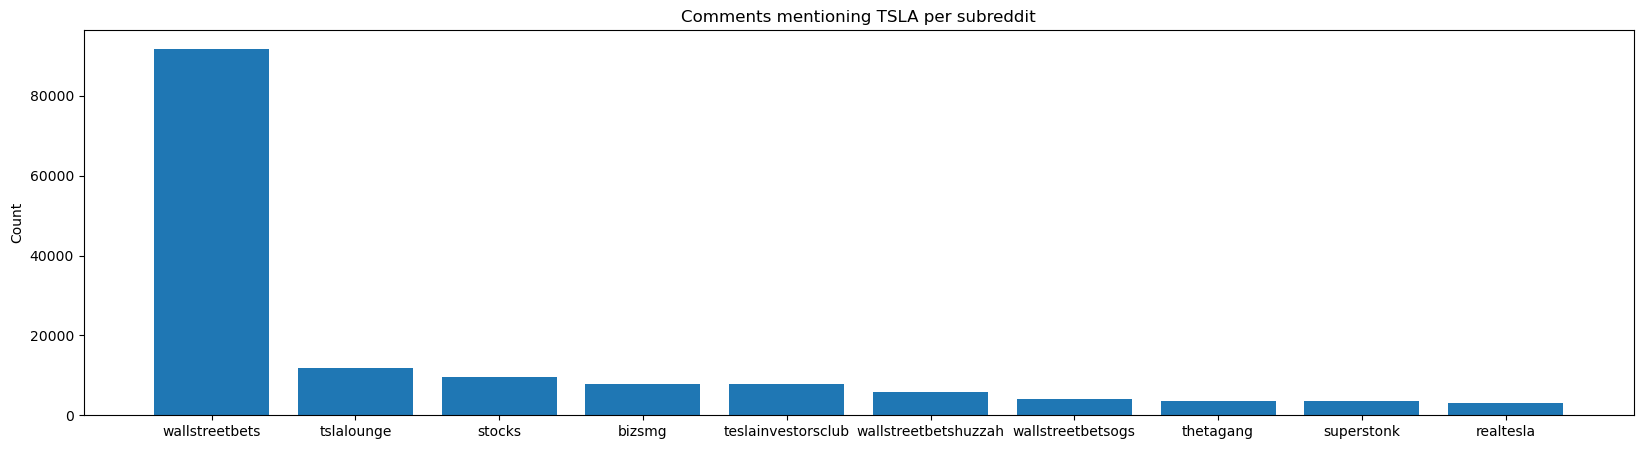

In [12]:
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(top_10_subs.index,top_10_subs)
ax.set_ylabel("Count")
ax.set_title("Comments mentioning TSLA per subreddit")

plt.show()

In [13]:
# aggregate average sentiment of comments on specific subreddits by date
for sub in top_10_subs.index:
    sentiment_new_col_name = f'{sub}_average_sentiment'
    reddit_tsla_df[sentiment_new_col_name] = reddit_tsla_df["ordinal_date"].apply(average_sentiment, args=[comments_df, sub])
    count_new_col_name = f'{sub}_comment_count'
    reddit_tsla_df[count_new_col_name] = reddit_tsla_df["ordinal_date"].apply(comment_count, args=[comments_df, sub])

In [14]:
# NOTE: NaN values in sentiment columns indicate days where no comments mentioning TSLA were made
reddit_tsla_df = reddit_tsla_df.sort_values(by="ordinal_date")
reddit_tsla_df

,datetime,ordinal_date,open,high,low,close,adj close,volume,reddit_average_sentiment,reddit_comment_count,...,wallstreetbetshuzzah_average_sentiment,wallstreetbetshuzzah_comment_count,wallstreetbetsogs_average_sentiment,wallstreetbetsogs_comment_count,thetagang_average_sentiment,thetagang_comment_count,superstonk_average_sentiment,superstonk_comment_count,realtesla_average_sentiment,realtesla_comment_count
0,2021-07-06,737977,227.236664,228.000000,217.133331,219.860001,219.860001,69853500,0.118076,398,...,-0.064645,11,0.218044,9,0.312833,9,0.222420,10,0.111714,14
1,2021-07-07,737978,221.423340,221.899994,212.773331,214.883331,214.883331,56376000,0.205677,373,...,-0.022750,16,0.479825,4,0.333670,23,0.430310,10,0.070986,7
2,2021-07-08,737979,209.456665,218.143326,206.820007,217.603333,217.603333,68319900,0.158132,409,...,0.085559,27,0.291150,8,0.281863,8,0.122850,6,0.396186,7
3,2021-07-09,737980,217.726669,219.636673,214.896667,218.983337,218.983337,54421500,0.153914,322,...,-0.055930,27,-0.046478,9,0.240069,13,0.060767,6,0.110210,10
4,2021-07-12,737983,220.733337,229.080002,220.720001,228.566666,228.566666,77781000,0.134264,405,...,-0.040823,13,0.069014,7,0.260750,14,0.334025,8,0.141213,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2022-06-27,738333,249.366669,252.070007,242.566666,244.919998,244.919998,89178300,0.080649,313,...,0.055783,6,-0.112400,8,0.368000,1,0.456400,1,0.392856,9
247,2022-06-28,738334,244.483337,249.970001,232.343338,232.663330,232.663330,90391200,0.133368,371,...,-0.012771,7,0.224311,9,0.579050,2,0.482750,4,0.376617,12
248,2022-06-29,738335,230.500000,231.173340,222.273331,228.490005,228.490005,82897200,0.056986,416,...,0.182269,13,-0.015100,8,0.335200,3,-0.730800,1,-0.252550,12
249,2022-06-30,738336,224.509995,229.456665,218.863327,224.473328,224.473328,94600500,0.069765,377,...,-0.085089,9,0.306450,10,0.586367,6,0.594900,3,0.420567,6


<u><h2>Exploratory data analysis</h2></u>

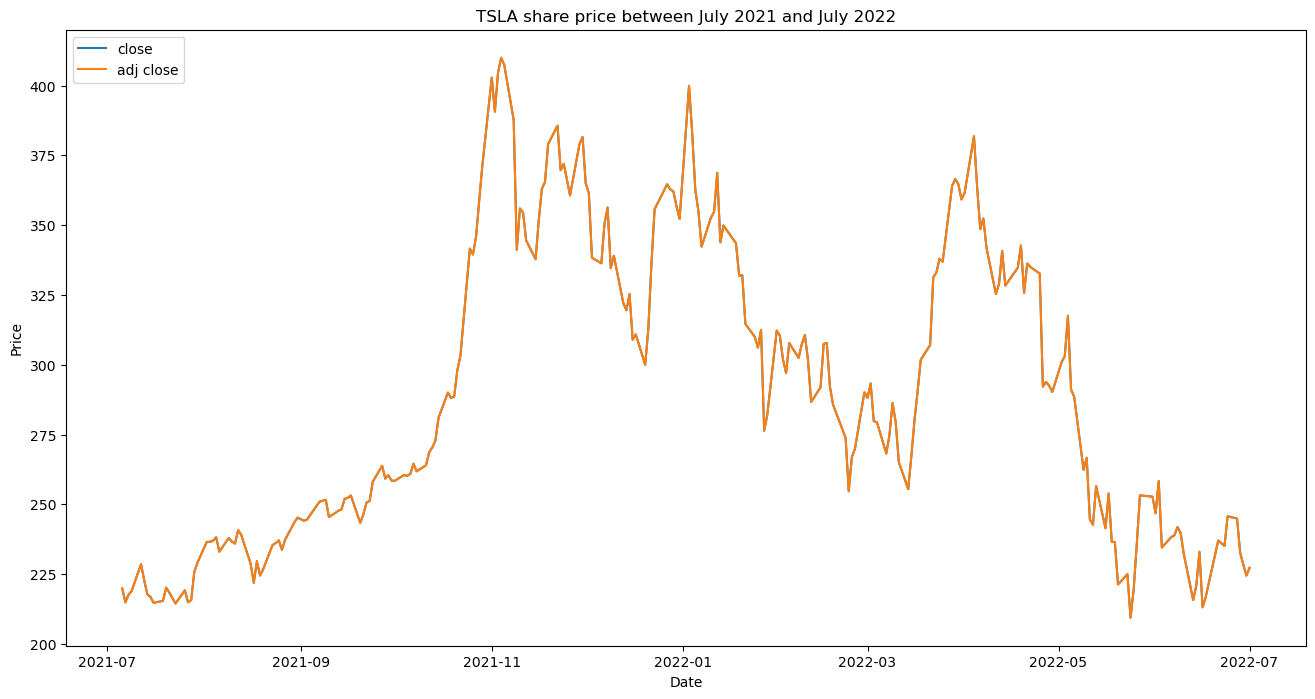

In [15]:
fig, ax = plt.subplots(figsize=(16,8))

for col in ["close","adj close"]:
    plt.plot(prices_df["datetime"], prices_df[col], label=col)

ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("TSLA share price between July 2021 and July 2022")
plt.legend(loc="upper left")

<h4>No significant difference between closing price and adjusted closing price.</h4>
<h4>For simplicity's sake, the un-adjusted closing price will be used for comparisons and predictions.</h4>

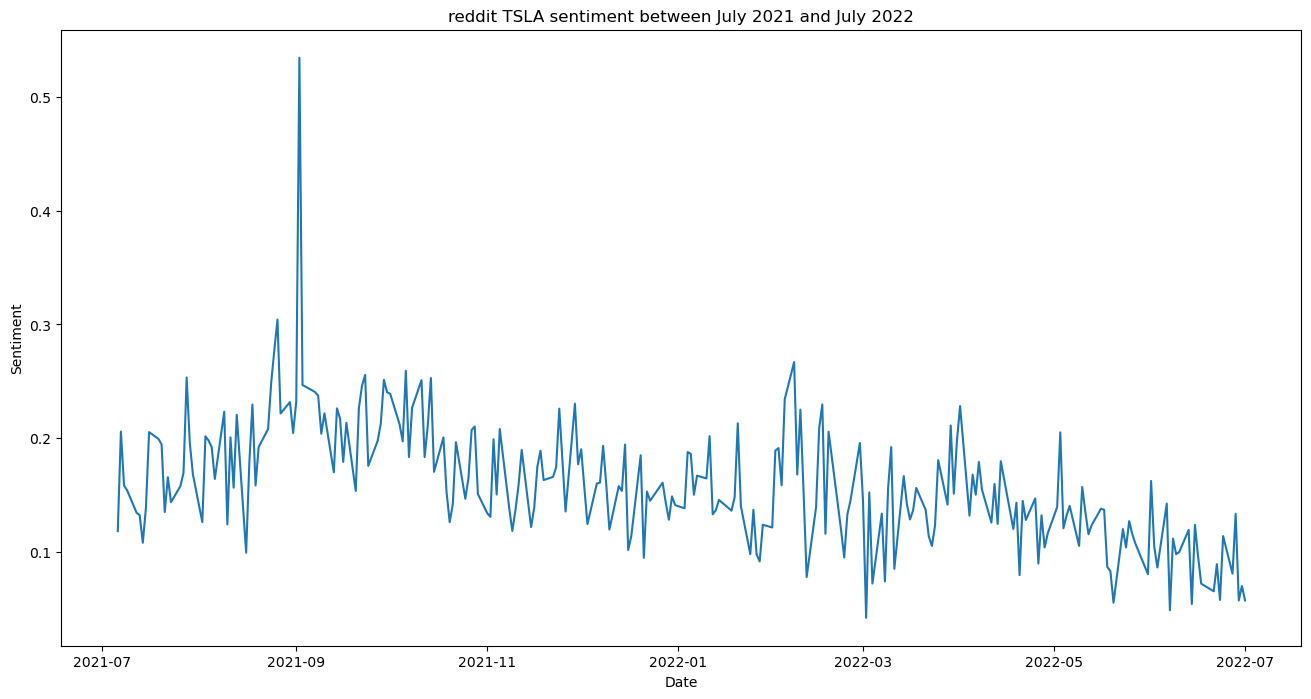

In [16]:
df = reddit_tsla_df
subreddit = "reddit"

fig, ax = plt.subplots(figsize=(16,8))

col_name = f'{subreddit}_average_sentiment'
plt.plot(df["datetime"], df[col_name], label=col)

ax.set_xlabel("Date")
ax.set_ylabel("Sentiment")
title = f'{subreddit} TSLA sentiment between July 2021 and July 2022'
ax.set_title(title)
plt.show()

<h4>Daily historical data appears to be too fine in detail. Let's see how things look when aggregating by week.</h4>

In [17]:
reddit_tsla_df

,datetime,ordinal_date,open,high,low,close,adj close,volume,reddit_average_sentiment,reddit_comment_count,...,wallstreetbetshuzzah_average_sentiment,wallstreetbetshuzzah_comment_count,wallstreetbetsogs_average_sentiment,wallstreetbetsogs_comment_count,thetagang_average_sentiment,thetagang_comment_count,superstonk_average_sentiment,superstonk_comment_count,realtesla_average_sentiment,realtesla_comment_count
0,2021-07-06,737977,227.236664,228.000000,217.133331,219.860001,219.860001,69853500,0.118076,398,...,-0.064645,11,0.218044,9,0.312833,9,0.222420,10,0.111714,14
1,2021-07-07,737978,221.423340,221.899994,212.773331,214.883331,214.883331,56376000,0.205677,373,...,-0.022750,16,0.479825,4,0.333670,23,0.430310,10,0.070986,7
2,2021-07-08,737979,209.456665,218.143326,206.820007,217.603333,217.603333,68319900,0.158132,409,...,0.085559,27,0.291150,8,0.281863,8,0.122850,6,0.396186,7
3,2021-07-09,737980,217.726669,219.636673,214.896667,218.983337,218.983337,54421500,0.153914,322,...,-0.055930,27,-0.046478,9,0.240069,13,0.060767,6,0.110210,10
4,2021-07-12,737983,220.733337,229.080002,220.720001,228.566666,228.566666,77781000,0.134264,405,...,-0.040823,13,0.069014,7,0.260750,14,0.334025,8,0.141213,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2022-06-27,738333,249.366669,252.070007,242.566666,244.919998,244.919998,89178300,0.080649,313,...,0.055783,6,-0.112400,8,0.368000,1,0.456400,1,0.392856,9
247,2022-06-28,738334,244.483337,249.970001,232.343338,232.663330,232.663330,90391200,0.133368,371,...,-0.012771,7,0.224311,9,0.579050,2,0.482750,4,0.376617,12
248,2022-06-29,738335,230.500000,231.173340,222.273331,228.490005,228.490005,82897200,0.056986,416,...,0.182269,13,-0.015100,8,0.335200,3,-0.730800,1,-0.252550,12
249,2022-06-30,738336,224.509995,229.456665,218.863327,224.473328,224.473328,94600500,0.069765,377,...,-0.085089,9,0.306450,10,0.586367,6,0.594900,3,0.420567,6


In [18]:
aggregate_first = ["datetime", "ordinal_date"]
aggregate_mean = ["open", "high", "low", "close", "adj close", "reddit_average_sentiment"]
aggregate_sum = ["volume", "reddit_comment_count"]
for sub in top_10_subs.index:
    aggregate_mean.append(f'{sub}_average_sentiment')
    aggregate_sum.append(f'{sub}_comment_count')

aggregate_dict = {}

for label in list(reddit_tsla_df.columns):
    if label in aggregate_first:
        aggregate_dict[label] = lambda x: x.iloc[0]
    elif label in aggregate_mean:
        aggregate_dict[label] = "mean"
    elif label in aggregate_sum:
        aggregate_dict[label] = "sum"

In [19]:
weekly_reddit_tsla_array = []

for week_start in range(0, len(reddit_tsla_df), 7):
    if week_start + 7 < len(reddit_tsla_df):
        week_row = reddit_tsla_df[week_start:week_start + 7].aggregate(aggregate_dict)
        weekly_reddit_tsla_array.append(week_row)
    else:
        week_row = reddit_tsla_df[week_start:len(reddit_tsla_df)].aggregate(aggregate_dict)
        weekly_reddit_tsla_array.append(week_row)

weekly_reddit_tsla_df = pd.DataFrame(weekly_reddit_tsla_array,columns=reddit_tsla_df.columns)

In [20]:
rename_dict = {
    "datetime": "week_start_datetime",
    "ordinal_date": "week_start_ordinal_date",
    "open": "average_open",
    "high": "average_high",
    "low": "average_low",
    "close": "average_close",
    "adj close": "average_adj_close"
}

weekly_reddit_tsla_df = weekly_reddit_tsla_df.rename(columns=rename_dict)
weekly_reddit_tsla_df.head()

,week_start_datetime,week_start_ordinal_date,average_open,average_high,average_low,average_close,average_adj_close,volume,reddit_average_sentiment,reddit_comment_count,...,wallstreetbetshuzzah_average_sentiment,wallstreetbetshuzzah_comment_count,wallstreetbetsogs_average_sentiment,wallstreetbetsogs_comment_count,thetagang_average_sentiment,thetagang_comment_count,superstonk_average_sentiment,superstonk_comment_count,realtesla_average_sentiment,realtesla_comment_count
0,2021-07-06,737977,221.276191,224.865239,216.008096,220.076667,220.076667,454573800,0.144282,2672,...,-0.023514,136,0.132158,58,0.343203,108,0.097139,56,0.132708,77
1,2021-07-15,737986,217.017144,219.440948,213.050476,216.641429,216.641429,351086100,0.168806,2446,...,0.059636,132,0.186452,70,0.142108,69,0.169185,71,0.103818,74
2,2021-07-26,737997,223.900953,229.546668,220.521905,225.397145,225.397145,568330800,0.181687,3964,...,0.149246,211,0.187815,141,0.366551,109,0.304663,84,0.245097,97
3,2021-08-04,738006,237.243336,239.799046,234.694763,237.070001,237.070001,302857500,0.179697,2013,...,0.205292,58,0.095389,72,0.302619,38,0.499566,33,0.164868,40
4,2021-08-13,738015,229.413810,233.360003,225.284285,229.431904,229.431904,398699700,0.183510,2875,...,0.059817,57,0.170219,72,0.325985,49,0.179681,80,0.209878,53


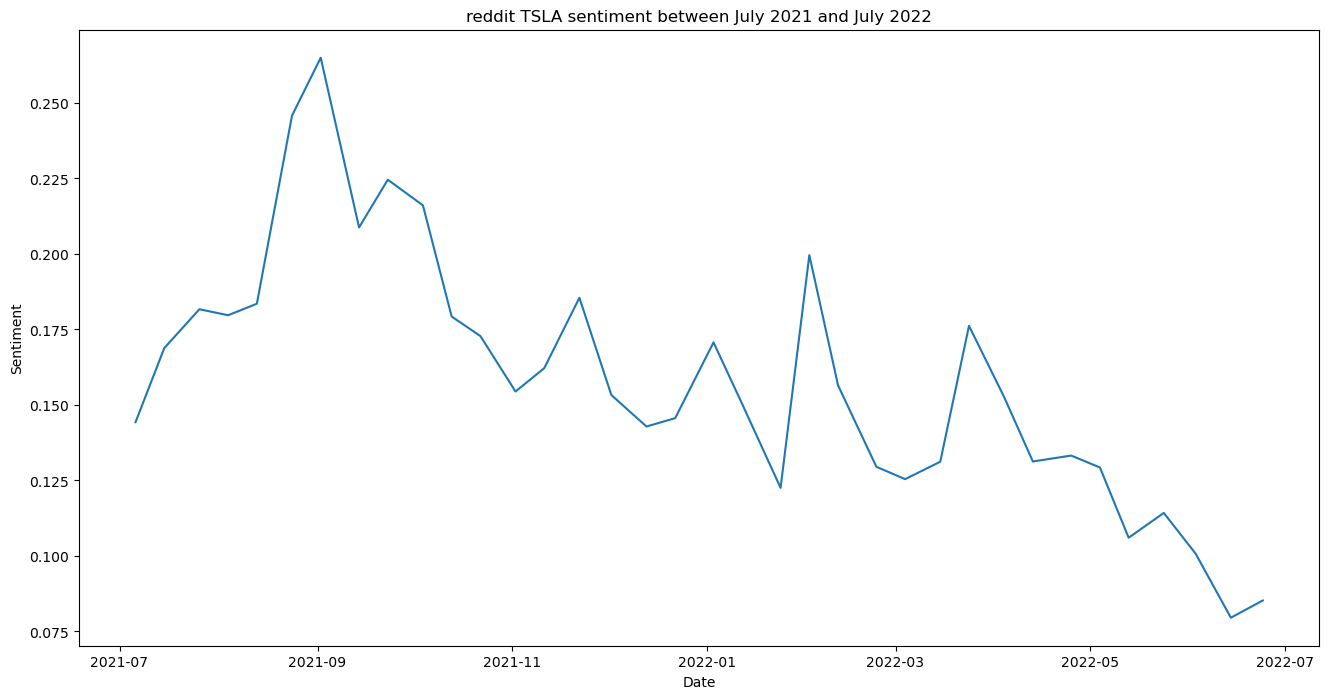

In [21]:
df = weekly_reddit_tsla_df
subreddit = "reddit"

fig, ax = plt.subplots(figsize=(16,8))

col_name = f'{subreddit}_average_sentiment'
plt.plot(df["week_start_datetime"], df[col_name], label=col)

ax.set_xlabel("Date")
ax.set_ylabel("Sentiment")
title = f'{subreddit} TSLA sentiment between July 2021 and July 2022'
ax.set_title(title)
plt.show()

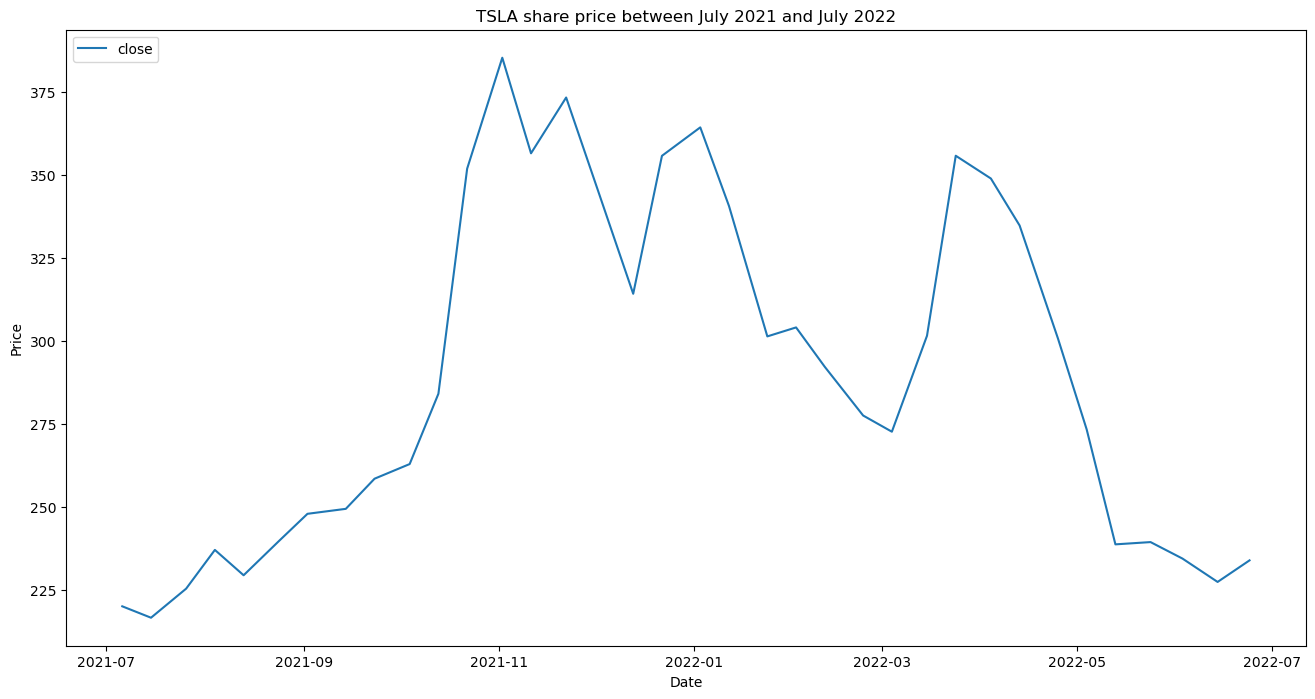

In [22]:
fig, ax = plt.subplots(figsize=(16,8))

plt.plot(weekly_reddit_tsla_df["week_start_datetime"], weekly_reddit_tsla_df["average_close"], label="close")

ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("TSLA share price between July 2021 and July 2022")
plt.legend(loc="upper left")

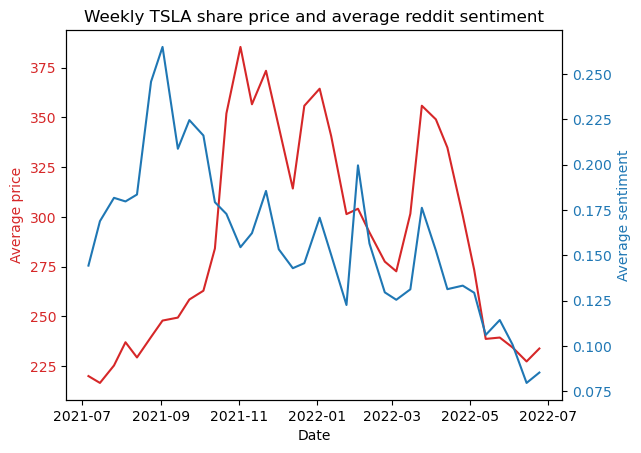

In [23]:
fig, ax1 = plt.subplots()

date_data = weekly_reddit_tsla_df["week_start_datetime"]

color1 = "tab:red"
ax1.set_xlabel("Date")
ax1.set_ylabel("Average price", color=color1)
ax1.plot(date_data, weekly_reddit_tsla_df["average_close"], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = "tab:blue"
ax2.set_ylabel("Average sentiment", color=color2)
ax2.plot(date_data, weekly_reddit_tsla_df["reddit_average_sentiment"], color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_title("Weekly TSLA share price and average reddit sentiment")

plt.show()

In [104]:
weekly_reddit_tsla_df.shape

(36, 31)

<h4>Looking at weekly averages smooths out the graph. Unfortunately, the limited data leaves us with only 36 data points after aggregating by week, so we will return to daily data.</h4>

<h4>Creating a feature representing the change in share price since the previous week. This feature should be more correlated with sentiment compared to price.</h4>

In [106]:
price_change_array = [0] # first value in dataset has unknown price change, will assume no change to preserve the datapoint
for i in range(1, len(reddit_tsla_df)):
    price_change = reddit_tsla_df["close"][i] - reddit_tsla_df["close"][i - 1]
    price_change_array.append(price_change)

In [107]:
reddit_tsla_df = reddit_tsla_df.assign(**{"close_delta" : np.nan})
reddit_tsla_df.loc[reddit_tsla_df.index, "close_delta"] = pd.Series(price_change_array)

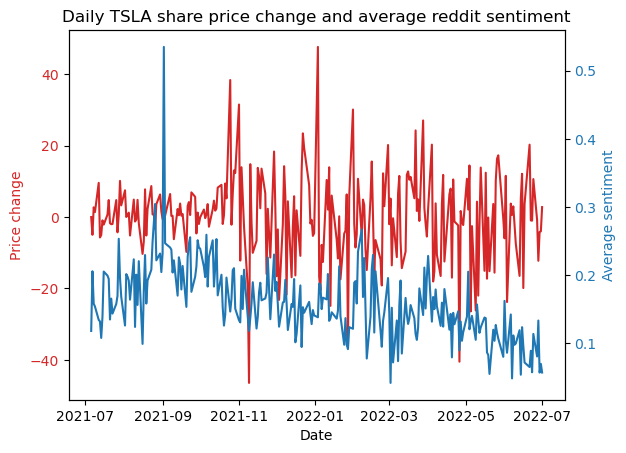

In [108]:
fig, ax1 = plt.subplots()

date_data = reddit_tsla_df["datetime"]

color1 = "tab:red"
ax1.set_xlabel("Date")
ax1.set_ylabel("Price change", color=color1)
ax1.plot(date_data, reddit_tsla_df["close_delta"], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = "tab:blue"
ax2.set_ylabel("Average sentiment", color=color2)
ax2.plot(date_data, reddit_tsla_df["reddit_average_sentiment"], color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_title("Daily TSLA share price change and average reddit sentiment")

plt.show()

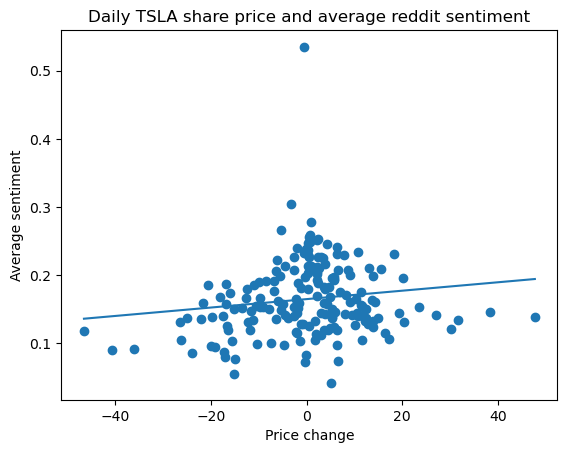

In [109]:
fig, ax = plt.subplots()
temp_df = reddit_tsla_df.dropna()

x = temp_df["close_delta"]
y = temp_df["reddit_average_sentiment"]
ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

ax.set_xlabel("Price change")
ax.set_ylabel("Average sentiment")
ax.set_title("Daily TSLA share price and average reddit sentiment")

plt.show()

<h4>Creating lag features to see if features in one week can predict features in the next week.</h4>

In [110]:
# code adapted with permission from university lecture
def create_lag_feature(df, orig_feature, lag, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)

    df = df.copy()
    new_df = df.assign(**{new_feature_name : np.nan})
    if lag < 0: # take values from the past
        new_df.loc[new_df.index[-lag:],new_feature_name] = new_df.iloc[:lag][orig_feature].values
    else:       # take values from the future
        new_df.loc[new_df.index[:-lag], new_feature_name] = new_df.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

In [111]:
price_lag_reddit_tsla_df = create_lag_feature(reddit_tsla_df, "close_delta", +1, "close_delta_next_day", clip=False)
price_lag_reddit_tsla_df.dropna(subset=["close_delta_next_day"], how='any', inplace=True)
price_lag_reddit_tsla_df.head()

,datetime,ordinal_date,open,high,low,close,adj close,volume,reddit_average_sentiment,reddit_comment_count,...,wallstreetbetsogs_average_sentiment,wallstreetbetsogs_comment_count,thetagang_average_sentiment,thetagang_comment_count,superstonk_average_sentiment,superstonk_comment_count,realtesla_average_sentiment,realtesla_comment_count,close_delta,close_delta_next_day
0,2021-07-06,737977,227.236664,228.000000,217.133331,219.860001,219.860001,69853500,0.118076,398,...,0.218044,9,0.312833,9,0.222420,10,0.111714,14,0.000000,-4.976670
1,2021-07-07,737978,221.423340,221.899994,212.773331,214.883331,214.883331,56376000,0.205677,373,...,0.479825,4,0.333670,23,0.430310,10,0.070986,7,-4.976670,2.720002
2,2021-07-08,737979,209.456665,218.143326,206.820007,217.603333,217.603333,68319900,0.158132,409,...,0.291150,8,0.281863,8,0.122850,6,0.396186,7,2.720002,1.380004
3,2021-07-09,737980,217.726669,219.636673,214.896667,218.983337,218.983337,54421500,0.153914,322,...,-0.046478,9,0.240069,13,0.060767,6,0.110210,10,1.380004,9.583329
4,2021-07-12,737983,220.733337,229.080002,220.720001,228.566666,228.566666,77781000,0.134264,405,...,0.069014,7,0.260750,14,0.334025,8,0.141213,8,9.583329,-5.720002


In [112]:
sentiment_lag_reddit_tsla_df = create_lag_feature(reddit_tsla_df, "reddit_average_sentiment", +1, "reddit_average_sentiment_next_day", clip=False)
sentiment_lag_reddit_tsla_df.dropna(subset=["reddit_average_sentiment_next_day"], how='any', inplace=True)
sentiment_lag_reddit_tsla_df.head()

,datetime,ordinal_date,open,high,low,close,adj close,volume,reddit_average_sentiment,reddit_comment_count,...,wallstreetbetsogs_average_sentiment,wallstreetbetsogs_comment_count,thetagang_average_sentiment,thetagang_comment_count,superstonk_average_sentiment,superstonk_comment_count,realtesla_average_sentiment,realtesla_comment_count,close_delta,reddit_average_sentiment_next_day
0,2021-07-06,737977,227.236664,228.000000,217.133331,219.860001,219.860001,69853500,0.118076,398,...,0.218044,9,0.312833,9,0.222420,10,0.111714,14,0.000000,0.205677
1,2021-07-07,737978,221.423340,221.899994,212.773331,214.883331,214.883331,56376000,0.205677,373,...,0.479825,4,0.333670,23,0.430310,10,0.070986,7,-4.976670,0.158132
2,2021-07-08,737979,209.456665,218.143326,206.820007,217.603333,217.603333,68319900,0.158132,409,...,0.291150,8,0.281863,8,0.122850,6,0.396186,7,2.720002,0.153914
3,2021-07-09,737980,217.726669,219.636673,214.896667,218.983337,218.983337,54421500,0.153914,322,...,-0.046478,9,0.240069,13,0.060767,6,0.110210,10,1.380004,0.134264
4,2021-07-12,737983,220.733337,229.080002,220.720001,228.566666,228.566666,77781000,0.134264,405,...,0.069014,7,0.260750,14,0.334025,8,0.141213,8,9.583329,0.132096


<u><h2>Linear regression</h2></u>

In [139]:
# code adapted with permission from university lectures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    drop_features,
    target
):

    all_features = set(numeric_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    new_columns = numeric_features

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df[target]
    y_test = test_df[target]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

<h4>Predicting price change using sentiment</h4>

In [140]:
price_lag_reddit_tsla_df.shape

(250, 32)

In [141]:
# 80 / 20 train test split
# time series data so not randomized
split_idx = math.floor(len(price_lag_reddit_tsla_df) * 0.8) - 1
split_date = price_lag_reddit_tsla_df["datetime"][split_idx]

predict_price_train = price_lag_reddit_tsla_df[price_lag_reddit_tsla_df["datetime"] <= split_date]
predict_price_test = price_lag_reddit_tsla_df[price_lag_reddit_tsla_df["datetime"] > split_date]

In [142]:
predict_price_train.shape

(200, 32)

In [143]:
predict_price_test.shape

(50, 32)

In [144]:
price_lag_reddit_tsla_df.columns

Index(['datetime', 'ordinal_date', 'open', 'high', 'low', 'close', 'adj close',
       'volume', 'reddit_average_sentiment', 'reddit_comment_count',
       'wallstreetbets_average_sentiment', 'wallstreetbets_comment_count',
       'tslalounge_average_sentiment', 'tslalounge_comment_count',
       'stocks_average_sentiment', 'stocks_comment_count',
       'bizsmg_average_sentiment', 'bizsmg_comment_count',
       'teslainvestorsclub_average_sentiment',
       'teslainvestorsclub_comment_count',
       'wallstreetbetshuzzah_average_sentiment',
       'wallstreetbetshuzzah_comment_count',
       'wallstreetbetsogs_average_sentiment',
       'wallstreetbetsogs_comment_count', 'thetagang_average_sentiment',
       'thetagang_comment_count', 'superstonk_average_sentiment',
       'superstonk_comment_count', 'realtesla_average_sentiment',
       'realtesla_comment_count', 'close_delta', 'close_delta_next_day'],
      dtype='object')

In [145]:
numeric_features = [
    'open', 'high', 'low', 'close', 'adj close',
    'volume', 'reddit_average_sentiment', 'reddit_comment_count',
    'wallstreetbets_average_sentiment', 'wallstreetbets_comment_count',
    'tslalounge_average_sentiment', 'tslalounge_comment_count',
    'stocks_average_sentiment', 'stocks_comment_count',
    'bizsmg_average_sentiment', 'bizsmg_comment_count',
    'teslainvestorsclub_average_sentiment',
    'teslainvestorsclub_comment_count',
    'wallstreetbetshuzzah_average_sentiment',
    'wallstreetbetshuzzah_comment_count',
    'wallstreetbetsogs_average_sentiment',
    'wallstreetbetsogs_comment_count', 'thetagang_average_sentiment',
    'thetagang_comment_count', 'superstonk_average_sentiment',
    'superstonk_comment_count', 'realtesla_average_sentiment',
    'realtesla_comment_count', 'close_delta'
]

drop_features = [
    "datetime",
    "ordinal_date"
]

target = ["close_delta_next_day"]

In [146]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    predict_price_train,
    predict_price_test,
    numeric_features,
    drop_features,
    target
)

In [147]:
from lightgbm import LGBMRegressor

In [148]:
lgbmr = LGBMRegressor(n_jobs=-1, random_state=123)
lgbmr_pipeline = make_pipeline(preprocessor, lgbmr)
lgbmr_pipeline.fit(predict_price_train, y_train)
print(lgbmr_pipeline.score(predict_price_train, y_train))
print(lgbmr_pipeline.score(predict_price_test, y_test))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 29
[LightGBM] [Info] Start training from score 0.529367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/danielchan/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [149]:
X_train = -predict_price_train['average_close_delta']
y_train = predict_price_train['average_close_delta_next_week']

predict_price_train_r2 = r2_score(y_true=y_train, y_pred=X_train)
predict_price_train_r2

KeyError: 'average_close_delta'

In [150]:
X_train

0     -0.000000
1      3.435237
2     -8.755715
3    -11.672856
4      7.638096
5    -10.258098
6     -8.256664
7     -1.495714
8     -9.079533
9     -4.412848
10   -21.189527
11   -67.802377
12   -33.418570
13    28.797625
14   -16.812867
15    28.116664
16    31.011915
17   -41.558101
18    -8.575234
19    23.711905
20    39.261427
21    -2.703810
22    11.884286
23    14.656189
24     4.876194
25   -28.909528
26   -54.228097
27     6.859523
Name: average_close_delta, dtype: float64

In [151]:
y_train

,close_delta_next_day
0,-4.976670
1,2.720002
2,1.380004
3,9.583329
4,-5.720002
...,...
195,11.806672
196,-12.456665
197,6.429992
198,7.953339


<h4>Predicting sentiment using price change</h4>

In [152]:
sentiment_lag_reddit_tsla_df.shape

(250, 32)

In [153]:
# 80 / 20 train test split
# time series data so not randomized
split_idx = math.floor(len(sentiment_lag_reddit_tsla_df) * 0.8) - 1
split_date = sentiment_lag_reddit_tsla_df["datetime"][split_idx]

predict_sentiment_train = sentiment_lag_reddit_tsla_df[sentiment_lag_reddit_tsla_df["datetime"] <= split_date]
predict_sentiment_test = sentiment_lag_reddit_tsla_df[sentiment_lag_reddit_tsla_df["datetime"] > split_date]

In [154]:
predict_sentiment_train.shape

(200, 32)

In [155]:
predict_sentiment_test.shape

(50, 32)

In [156]:
sentiment_lag_reddit_tsla_df.columns

Index(['datetime', 'ordinal_date', 'open', 'high', 'low', 'close', 'adj close',
       'volume', 'reddit_average_sentiment', 'reddit_comment_count',
       'wallstreetbets_average_sentiment', 'wallstreetbets_comment_count',
       'tslalounge_average_sentiment', 'tslalounge_comment_count',
       'stocks_average_sentiment', 'stocks_comment_count',
       'bizsmg_average_sentiment', 'bizsmg_comment_count',
       'teslainvestorsclub_average_sentiment',
       'teslainvestorsclub_comment_count',
       'wallstreetbetshuzzah_average_sentiment',
       'wallstreetbetshuzzah_comment_count',
       'wallstreetbetsogs_average_sentiment',
       'wallstreetbetsogs_comment_count', 'thetagang_average_sentiment',
       'thetagang_comment_count', 'superstonk_average_sentiment',
       'superstonk_comment_count', 'realtesla_average_sentiment',
       'realtesla_comment_count', 'close_delta',
       'reddit_average_sentiment_next_day'],
      dtype='object')

In [157]:
numeric_features = [
    'open', 'high', 'low', 'close', 'adj close',
    'volume', 'reddit_average_sentiment', 'reddit_comment_count',
    'wallstreetbets_average_sentiment', 'wallstreetbets_comment_count',
    'tslalounge_average_sentiment', 'tslalounge_comment_count',
    'stocks_average_sentiment', 'stocks_comment_count',
    'bizsmg_average_sentiment', 'bizsmg_comment_count',
    'teslainvestorsclub_average_sentiment',
    'teslainvestorsclub_comment_count',
    'wallstreetbetshuzzah_average_sentiment',
    'wallstreetbetshuzzah_comment_count',
    'wallstreetbetsogs_average_sentiment',
    'wallstreetbetsogs_comment_count', 'thetagang_average_sentiment',
    'thetagang_comment_count', 'superstonk_average_sentiment',
    'superstonk_comment_count', 'realtesla_average_sentiment',
    'realtesla_comment_count', 'close_delta'
]

drop_features = [
    "datetime",
    "ordinal_date"
]

target = ["reddit_average_sentiment_next_day"]

In [158]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    predict_sentiment_train,
    predict_sentiment_test,
    numeric_features,
    drop_features,
    target
)

In [159]:
lgbmr = LGBMRegressor(n_jobs=-1, random_state=123)
lgbmr_pipeline = make_pipeline(preprocessor, lgbmr)
lgbmr_pipeline.fit(predict_sentiment_train, y_train)
print(lgbmr_pipeline.score(predict_sentiment_train, y_train))
print(lgbmr_pipeline.score(predict_sentiment_test, y_test))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 29
[LightGBM] [Info] Start training from score 0.171644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/danielchan/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<u><h2>Conclusions and future directions</h2></u>

We were able to predict neither the next day's price change based on today's stock data and Reddit sentiment or the next day's Reddit sentiment based on today's stock data and price change. Possible explanations for the findings include the small amount of data used: the Reddit data constrained the stock data to a one-year period, which yielded only 250 data points. Another possibility is that it is truly not feasible to predict price changes using Reddit sentiment

In [ ]:
<h4>Research questions:</h4>

- There have been instances where individuals are influenced by social media to purchase shares at inflated prices, which could further drive up the share price. Large gains in value over a short period of time then incites further excitement on social media. Which of these factors is stronger? Does sentiment on Reddit predict changes in share price, or does share price predict sentiment on Reddit?
- Are some subreddits better at predicting share price than others? Which communities are more 'reactionary' and which are more 'predictive'?
- Is the score of a post/comment an indicator of its reliability? Do higher scoring posts/comments have higher predictive utility compared to lower scoring ones?